<a href="https://colab.research.google.com/github/RenneeWang/DQN_and_DRQN/blob/main/TFDF_Onion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, integrate
import seaborn as sns

In [2]:
!pip install tensorflow_decision_forests
!pip install wurlitzer

     |████████████████████████████████| 6.3 MB 4.4 MB/s 


In [3]:
import tensorflow_decision_forests as tfdf

import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

In [4]:
from copy import deepcopy

In [5]:
# labels
df = pd.read_excel('/content/olfactory_labels_1018.xlsx')
df.head()

,chemical_name,cas,smiles,leffingwell,fema,fema no,sum,fruity,green,sweet,floral,fatty,herbal,sulfurous,spicy,nutty,apple,fresh,waxy,woody,savory,citrus,meaty,roasted,oily,tropical,ethereal,earthy,rose,winey,balsamic,caramellic,vegetable,mint,pineapple,cheesy,burnt,pungent,onion,dairy,...,overripe fruity,organic,oats,nutmeg,mocha,menthol,marshmallow,linoleum,lily,licorice,lettuce,lemon peel,lactone,kiwi,iron scorch,harsh,greenery,gravy,glue,fir,fabric,eucalyptol,dull,dry fish,dill,dandelion,cresol,cotton,cooked,contact glue,cereal,carbide,burnt matches,brown sugar,box tree,bell pepper,beeswaxy,basil,baked,bayberry
0,Acetal,105-57-7,CCOC(C)OCC,"['green', 'fruity', 'alcoholic']","Creamy, Fruit, Pleasant, Tropical Fruit",2002.0,9,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Acetaldehyde phenethyl propyl acetal,7493-57-4,CCCOC(C)OCCC1=CC=CC=C1,"['green', 'leafy', 'floral']",Green Leaf,2004.0,5,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Acetanisole,100-06-1,CC(=O)C1=CC=C(C=C1)OC,"['hay', 'floral', 'sweet']",Bitter,2005.0,4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Triacetin,102-76-1,CC(=O)OCC(COC(=O)C)OC(=O)C,"['fruity', 'ethereal']",0,2007.0,5,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Acetoin,513-86-0,CC(C(=O)C)O,"['creamy', 'buttery']","Butter, Creamy, Green Pepper",2008.0,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
MACCS = pd.read_csv('/content/MACCS_1018.csv',encoding="utf-8")
MACCS.head()

,chemical_name,cas,smiles,maccs_0,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,maccs_10,maccs_11,maccs_12,maccs_13,maccs_14,maccs_15,maccs_16,maccs_17,maccs_18,maccs_19,maccs_20,maccs_21,maccs_22,maccs_23,maccs_24,maccs_25,maccs_26,maccs_27,maccs_28,maccs_29,maccs_30,maccs_31,maccs_32,maccs_33,maccs_34,maccs_35,maccs_36,...,maccs_127,maccs_128,maccs_129,maccs_130,maccs_131,maccs_132,maccs_133,maccs_134,maccs_135,maccs_136,maccs_137,maccs_138,maccs_139,maccs_140,maccs_141,maccs_142,maccs_143,maccs_144,maccs_145,maccs_146,maccs_147,maccs_148,maccs_149,maccs_150,maccs_151,maccs_152,maccs_153,maccs_154,maccs_155,maccs_156,maccs_157,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166
0,Acetal,105-57-7,CCOC(C)OCC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,0,1,0,0
1,Acetaldehyde phenethyl propyl acetal,7493-57-4,CCCOC(C)OCCC1=CC=CC=C1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,1,0,1,1,1,1,0
2,Acetanisole,100-06-1,CC(=O)C1=CC=C(C=C1)OC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,1,1,1,1,0
3,Triacetin,102-76-1,CC(=O)OCC(COC(=O)C)OC(=O)C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1,1,1,1,0,1,0,1,1,0,0,0,1,0,0
4,Acetoin,513-86-0,CC(C(=O)C)O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0


In [70]:
def encoding(x):
    encode = ['no','yes']
    return encode[x]

for n in MACCS.columns[3:]:
    MACCS[n] = MACCS[n].map(encoding)
MACCS.head()

,chemical_name,cas,smiles,maccs_0,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,maccs_10,maccs_11,maccs_12,maccs_13,maccs_14,maccs_15,maccs_16,maccs_17,maccs_18,maccs_19,maccs_20,maccs_21,maccs_22,maccs_23,maccs_24,maccs_25,maccs_26,maccs_27,maccs_28,maccs_29,maccs_30,maccs_31,maccs_32,maccs_33,maccs_34,maccs_35,maccs_36,...,maccs_127,maccs_128,maccs_129,maccs_130,maccs_131,maccs_132,maccs_133,maccs_134,maccs_135,maccs_136,maccs_137,maccs_138,maccs_139,maccs_140,maccs_141,maccs_142,maccs_143,maccs_144,maccs_145,maccs_146,maccs_147,maccs_148,maccs_149,maccs_150,maccs_151,maccs_152,maccs_153,maccs_154,maccs_155,maccs_156,maccs_157,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166
0,Acetal,105-57-7,CCOC(C)OCC,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,no,yes,no,no,no,no,no,no,no,no,no,yes,no,no,yes,no,no,no,no,no,no,no,yes,no,no,no,yes,no,yes,no,yes,no,yes,yes,no,no,no,yes,no,no
1,Acetaldehyde phenethyl propyl acetal,7493-57-4,CCCOC(C)OCCC1=CC=CC=C1,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,no,yes,no,no,no,yes,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,yes,no,yes,no,no,no,yes,no,yes,no,yes,no,yes,yes,no,yes,yes,yes,yes,no
2,Acetanisole,100-06-1,CC(=O)C1=CC=C(C=C1)OC,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,yes,no,no,yes,no,yes,no,no,yes,no,yes,yes,no,yes,yes,yes,yes,no
3,Triacetin,102-76-1,CC(=O)OCC(COC(=O)C)OC(=O)C,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,no,no,no,no,no,yes,no,no,no,yes,no,yes,no,yes,yes,no,no,no,no,yes,no,no,yes,no,no,yes,yes,yes,yes,no,yes,no,yes,yes,no,no,no,yes,no,no
4,Acetoin,513-86-0,CC(C(=O)C)O,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,yes,no,no,yes,no,yes,no,no,yes,no,yes,yes,no,no,no,yes,no,no


In [34]:
F = pd.read_csv('/content/features_1024.csv')
F.head()

,chemical_name,cas,smiles,main_length,ring_num,main_C,main_S,main_N,main_O,main_I,main_double_C,main_double_N,main_double_S,main_double_O,num_side,max_side,min_side,side_C,side_S,side_N,side_O,side_I,side_double_C,side_double_N,side_double_S,side_double_O,triple_C,triple_N,Cl,Br,F,carboxyl,keto,carbonyl,hydroxy
0,Acetal,105-57-7,CCOC(C)OCC,7,0.0,5,0,0,2,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Acetaldehyde phenethyl propyl acetal,7493-57-4,CCCOC(C)OCCC1=CC=CC=C1,14,1.0,12,0,0,2,0,3,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Acetanisole,100-06-1,CC(=O)C1=CC=C(C=C1)OC,8,1.0,7,0,0,1,0,2,0,0,0,2,2,1,2,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
3,Triacetin,102-76-1,CC(=O)OCC(COC(=O)C)OC(=O)C,12,0.0,9,0,0,3,0,0,0,0,0,3,5,1,3,0,0,4,0,0,0,0,3,0,0,0,0,0,1,1,3,0
4,Acetoin,513-86-0,CC(C(=O)C)O,3,0.0,2,0,0,1,0,0,0,0,0,1,3,3,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1


In [31]:
MACCS.shape, df.shape, F.shape

((3736, 170), (3736, 223), (3736, 34))

In [11]:
Top30 = list(df.columns[7:37])
Top30

['fruity',
 'green',
 'sweet',
 'floral',
 'fatty',
 'herbal',
 'sulfurous',
 'spicy',
 'nutty',
 'apple',
 'fresh',
 'waxy',
 'woody',
 'savory',
 'citrus',
 'meaty',
 'roasted',
 'oily',
 'tropical',
 'ethereal',
 'earthy',
 'rose',
 'winey',
 'balsamic',
 'caramellic',
 'vegetable',
 'mint',
 'pineapple',
 'cheesy',
 'burnt']

In [71]:
MACCS_onion = pd.merge(MACCS,df[['chemical_name','cas','smiles']+Top30+['onion']],on=['chemical_name','cas','smiles'],how='inner')
MACCS_onion.shape

(3736, 201)

In [75]:
for n in Top30:
    MACCS_onion[n] = MACCS_onion[n].map(encoding)
MACCS_onion.head()

,chemical_name,cas,smiles,maccs_0,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,maccs_10,maccs_11,maccs_12,maccs_13,maccs_14,maccs_15,maccs_16,maccs_17,maccs_18,maccs_19,maccs_20,maccs_21,maccs_22,maccs_23,maccs_24,maccs_25,maccs_26,maccs_27,maccs_28,maccs_29,maccs_30,maccs_31,maccs_32,maccs_33,maccs_34,maccs_35,maccs_36,...,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166,fruity,green,sweet,floral,fatty,herbal,sulfurous,spicy,nutty,apple,fresh,waxy,woody,savory,citrus,meaty,roasted,oily,tropical,ethereal,earthy,rose,winey,balsamic,caramellic,vegetable,mint,pineapple,cheesy,burnt,onion
0,Acetal,105-57-7,CCOC(C)OCC,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,no,yes,yes,no,no,no,yes,no,no,yes,yes,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,0
1,Acetaldehyde phenethyl propyl acetal,7493-57-4,CCCOC(C)OCCC1=CC=CC=C1,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,no,yes,yes,no,yes,yes,yes,yes,no,no,yes,no,yes,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,0
2,Acetanisole,100-06-1,CC(=O)C1=CC=C(C=C1)OC,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,no,yes,yes,no,yes,yes,yes,yes,no,no,no,yes,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,0
3,Triacetin,102-76-1,CC(=O)OCC(COC(=O)C)OC(=O)C,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,no,yes,yes,no,no,no,yes,no,no,yes,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,0
4,Acetoin,513-86-0,CC(C(=O)C)O,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,no,yes,yes,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,0


In [72]:
F_onion = pd.merge(F,df[['chemical_name','cas','smiles']+Top30+['onion']],on=['chemical_name','cas','smiles'],how='left')
F_onion.shape

(3736, 66)

In [76]:
for n in Top30:
    F_onion[n] = F_onion[n].map(encoding)
F_onion.head()

,chemical_name,cas,smiles,main_length,ring_num,main_C,main_S,main_N,main_O,main_I,main_double_C,main_double_N,main_double_S,main_double_O,num_side,max_side,min_side,side_C,side_S,side_N,side_O,side_I,side_double_C,side_double_N,side_double_S,side_double_O,triple_C,triple_N,Cl,Br,F,carboxyl,keto,carbonyl,hydroxy,fruity,green,sweet,floral,fatty,herbal,sulfurous,spicy,nutty,apple,fresh,waxy,woody,savory,citrus,meaty,roasted,oily,tropical,ethereal,earthy,rose,winey,balsamic,caramellic,vegetable,mint,pineapple,cheesy,burnt,onion
0,Acetal,105-57-7,CCOC(C)OCC,7,0.0,5,0,0,2,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,yes,yes,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,0
1,Acetaldehyde phenethyl propyl acetal,7493-57-4,CCCOC(C)OCCC1=CC=CC=C1,14,1.0,12,0,0,2,0,3,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,no,yes,no,yes,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,0
2,Acetanisole,100-06-1,CC(=O)C1=CC=C(C=C1)OC,8,1.0,7,0,0,1,0,2,0,0,0,2,2,1,2,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,no,no,yes,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,0
3,Triacetin,102-76-1,CC(=O)OCC(COC(=O)C)OC(=O)C,12,0.0,9,0,0,3,0,0,0,0,0,3,5,1,3,0,0,4,0,0,0,0,3,0,0,0,0,0,1,1,3,0,yes,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,0
4,Acetoin,513-86-0,CC(C(=O)C)O,3,0.0,2,0,0,1,0,0,0,0,0,1,3,3,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,0


In [73]:
MF_onion = pd.merge(MACCS,F_onion,on=['chemical_name','cas','smiles'])
MF_onion.shape

(3736, 233)

In [78]:
for n in Top30:
    MF_onion[n] = MF_onion[n].map(encoding)
MF_onion.head()

,chemical_name,cas,smiles,maccs_0,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,maccs_10,maccs_11,maccs_12,maccs_13,maccs_14,maccs_15,maccs_16,maccs_17,maccs_18,maccs_19,maccs_20,maccs_21,maccs_22,maccs_23,maccs_24,maccs_25,maccs_26,maccs_27,maccs_28,maccs_29,maccs_30,maccs_31,maccs_32,maccs_33,maccs_34,maccs_35,maccs_36,...,triple_C,triple_N,Cl,Br,F,carboxyl,keto,carbonyl,hydroxy,fruity,green,sweet,floral,fatty,herbal,sulfurous,spicy,nutty,apple,fresh,waxy,woody,savory,citrus,meaty,roasted,oily,tropical,ethereal,earthy,rose,winey,balsamic,caramellic,vegetable,mint,pineapple,cheesy,burnt,onion
0,Acetal,105-57-7,CCOC(C)OCC,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,0,0,0,0,0,0,1,0,0,yes,yes,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,0
1,Acetaldehyde phenethyl propyl acetal,7493-57-4,CCCOC(C)OCCC1=CC=CC=C1,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,0,0,0,0,0,0,1,0,0,no,yes,no,yes,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,0
2,Acetanisole,100-06-1,CC(=O)C1=CC=C(C=C1)OC,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,0,0,0,0,0,0,0,1,0,no,no,yes,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,0
3,Triacetin,102-76-1,CC(=O)OCC(COC(=O)C)OC(=O)C,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,0,0,0,0,0,1,1,3,0,yes,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,0
4,Acetoin,513-86-0,CC(C(=O)C)O,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,0,0,0,0,0,0,0,1,1,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,0


In [41]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.30):
    """Splits a panda dataframe in two."""
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]



# MACCS

In [79]:
label = "onion"

classes = MACCS_onion[label].unique().tolist()
print(f"Label classes: {classes}")

MACCS_onion[label] = MACCS_onion[label].map(classes.index)

Label classes: [0, 1]


In [80]:
train_ds_pd, test_ds_pd = split_dataset(MACCS_onion.iloc[:,3:])
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

2605 examples in training, 1131 examples for testing.


In [81]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label='onion')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label='onion')

In [82]:
# %set_cell_height 300

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(compute_oob_variable_importances=True)

# Optionally, add evaluation metrics.
model_1.compile(
    metrics=["accuracy","AUC","Recall","Precision"])

In [83]:
# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_1.fit(x=train_ds)

41/41 [==============================] - 2s 17ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 41
[INFO kernel.cc:393] Number of examples: 2605
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column maccs_103 (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column maccs_107 (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column maccs_13 (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column maccs_134 (1 item(s) left) because min_value_count=5 and ma

In [84]:
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

18/18 [==============================] - 3s 20ms/step - loss: 0.0000e+00 - accuracy: 0.9699 - auc: 0.9716 - recall: 0.2250 - precision: 0.7500

loss: 0.0000
accuracy: 0.9699
auc: 0.9716
recall: 0.2250
precision: 0.7500


In [85]:
inspector = model_1.make_inspector()

In [86]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 MEAN_DECREASE_IN_AUC_2_VS_OTHERS
	 NUM_NODES
	 MEAN_DECREASE_IN_ACCURACY
	 MEAN_DECREASE_IN_PRAUC_2_VS_OTHERS
	 MEAN_MIN_DEPTH
	 SUM_SCORE
	 MEAN_DECREASE_IN_AP_2_VS_OTHERS
	 NUM_AS_ROOT


In [87]:
mda = inspector.variable_importances()["MEAN_DECREASE_IN_ACCURACY"]
mdauc = inspector.variable_importances()["MEAN_DECREASE_IN_AUC_2_VS_OTHERS"]
nsr = inspector.variable_importances()['NUM_AS_ROOT']
ss = inspector.variable_importances()['SUM_SCORE']

In [52]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt



In [53]:
def RV0(series):
  return series[0]

def RV1(series):
  return series[1]

def RV2(series):
  return series[2]


### MDA MEAN DECREASE IN ACCURACY

In [88]:
mda_pd = pd.DataFrame(mda,columns=['variables','importance'])
mda_pd['variable'] = mda_pd.variables.apply(RV0)
mda_pd['type'] = mda_pd.variables.apply(RV1)
mda_pd['id'] = mda_pd.variables.apply(RV2)

In [89]:
mda_pd.head()

,variables,importance,variable,type,id
0,"(sulfurous, 4, 190)",0.001919,sulfurous,4,190
1,"(meaty, 4, 181)",0.001535,meaty,4,181
2,"(maccs_14, 4, 60)",0.000768,maccs_14,4,60
3,"(vegetable, 4, 193)",0.000768,vegetable,4,193
4,"(maccs_164, 4, 87)",0.000768,maccs_164,4,87


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'A. Mean Decrease In Accuracy (Top 20)')

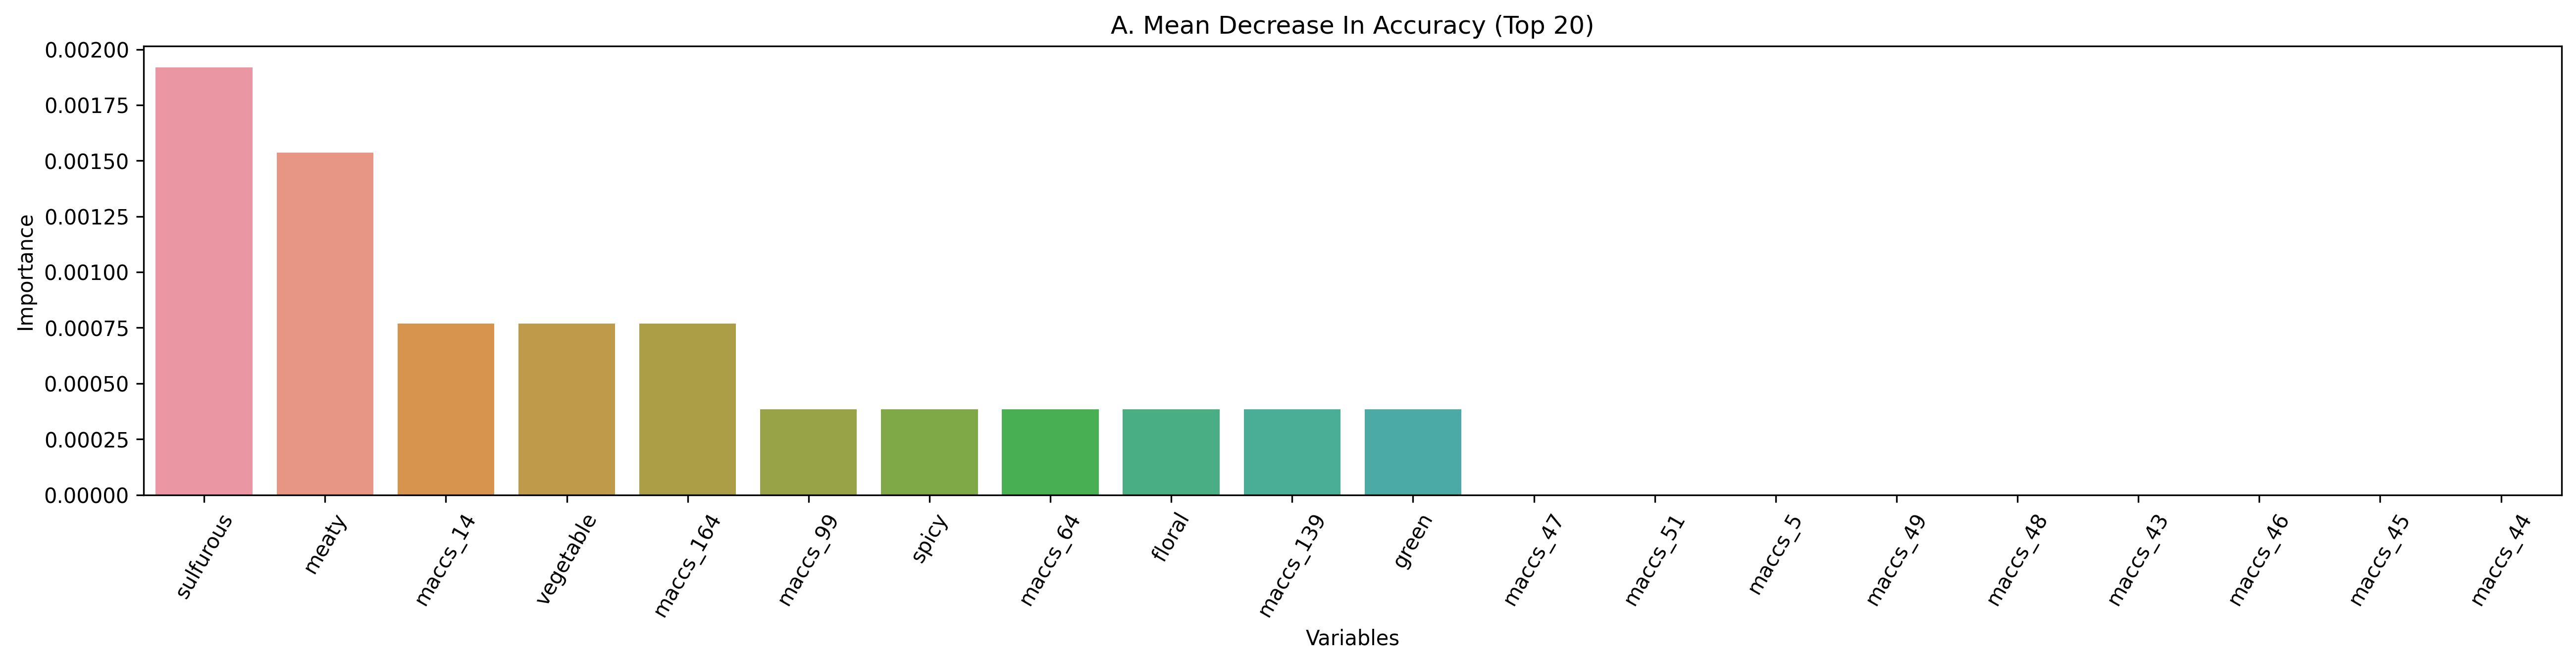

In [90]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(mda_pd['variable'][:20], mda_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Importance')

plt.title('A. Mean Decrease In Accuracy (Top 20)')

### MDAUC MEAN_DECREASE_IN_AUC_2_VS_OTHERS

In [91]:
mdauc_pd = pd.DataFrame(mdauc,columns=['variables','importance'])
mdauc_pd['variable'] = mdauc_pd.variables.apply(RV0)
mdauc_pd['type'] = mdauc_pd.variables.apply(RV1)
mdauc_pd['id'] = mdauc_pd.variables.apply(RV2)

In [92]:
mdauc_pd.head()

,variables,importance,variable,type,id
0,"(maccs_88, 4, 168)",0.040131,maccs_88,4,168
1,"(maccs_124, 4, 43)",0.003335,maccs_124,4,43
2,"(maccs_67, 4, 145)",0.003307,maccs_67,4,145
3,"(meaty, 4, 181)",0.003137,meaty,4,181
4,"(maccs_81, 4, 161)",0.002701,maccs_81,4,161


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'B. Mean Decrease In ROC AUC (Top 20)')

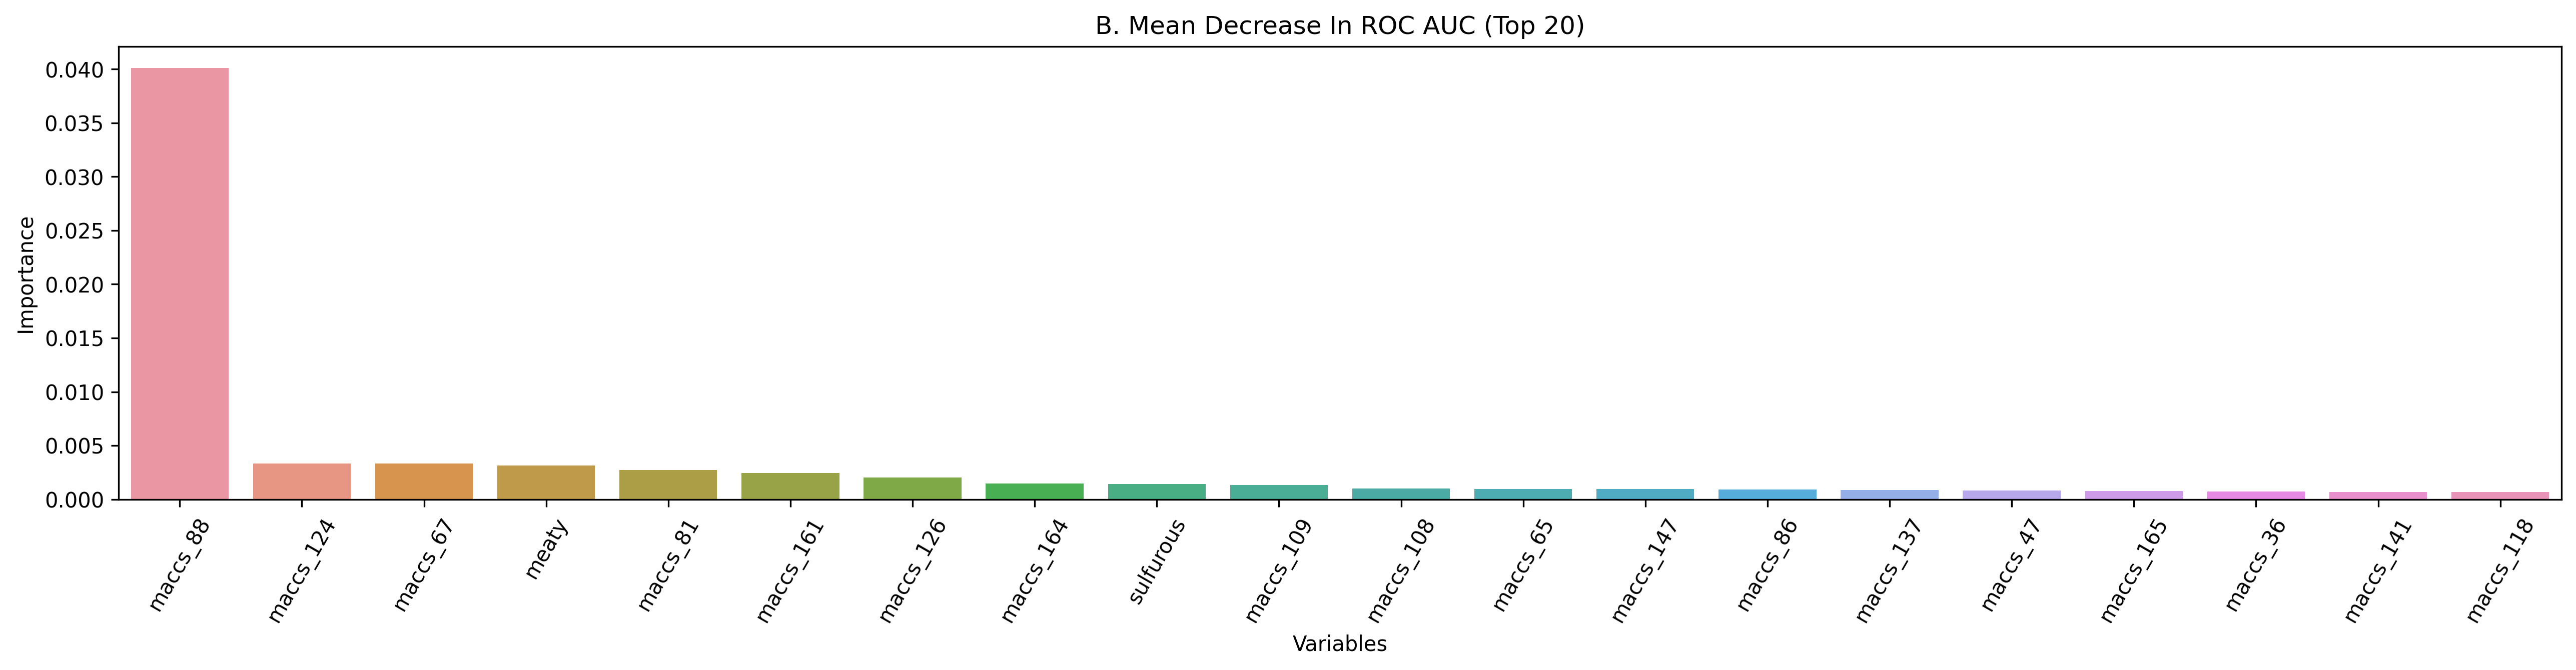

In [93]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(mdauc_pd['variable'][:20], mdauc_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Importance')

plt.title('B. Mean Decrease In ROC AUC (Top 20)')

### NSR NUM_AS_ROOT

In [94]:
nsr_pd = pd.DataFrame(nsr,columns=['variables','importance'])
nsr_pd['variable'] = nsr_pd.variables.apply(RV0)
nsr_pd['type'] = nsr_pd.variables.apply(RV1)
nsr_pd['id'] = nsr_pd.variables.apply(RV2)

In [95]:
nsr_pd.head()

,variables,importance,variable,type,id
0,"(maccs_88, 4, 168)",39.0,maccs_88,4,168
1,"(maccs_14, 4, 60)",33.0,maccs_14,4,60
2,"(maccs_67, 4, 145)",28.0,maccs_67,4,145
3,"(maccs_124, 4, 43)",22.0,maccs_124,4,43
4,"(maccs_157, 4, 79)",20.0,maccs_157,4,79
5,"(maccs_154, 4, 76)",16.0,maccs_154,4,76
6,"(savory, 4, 188)",15.0,savory,4,188
7,"(maccs_81, 4, 161)",13.0,maccs_81,4,161
8,"(sulfurous, 4, 190)",13.0,sulfurous,4,190
9,"(maccs_130, 4, 50)",12.0,maccs_130,4,50


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'C. Number of As Root (Top 20)')

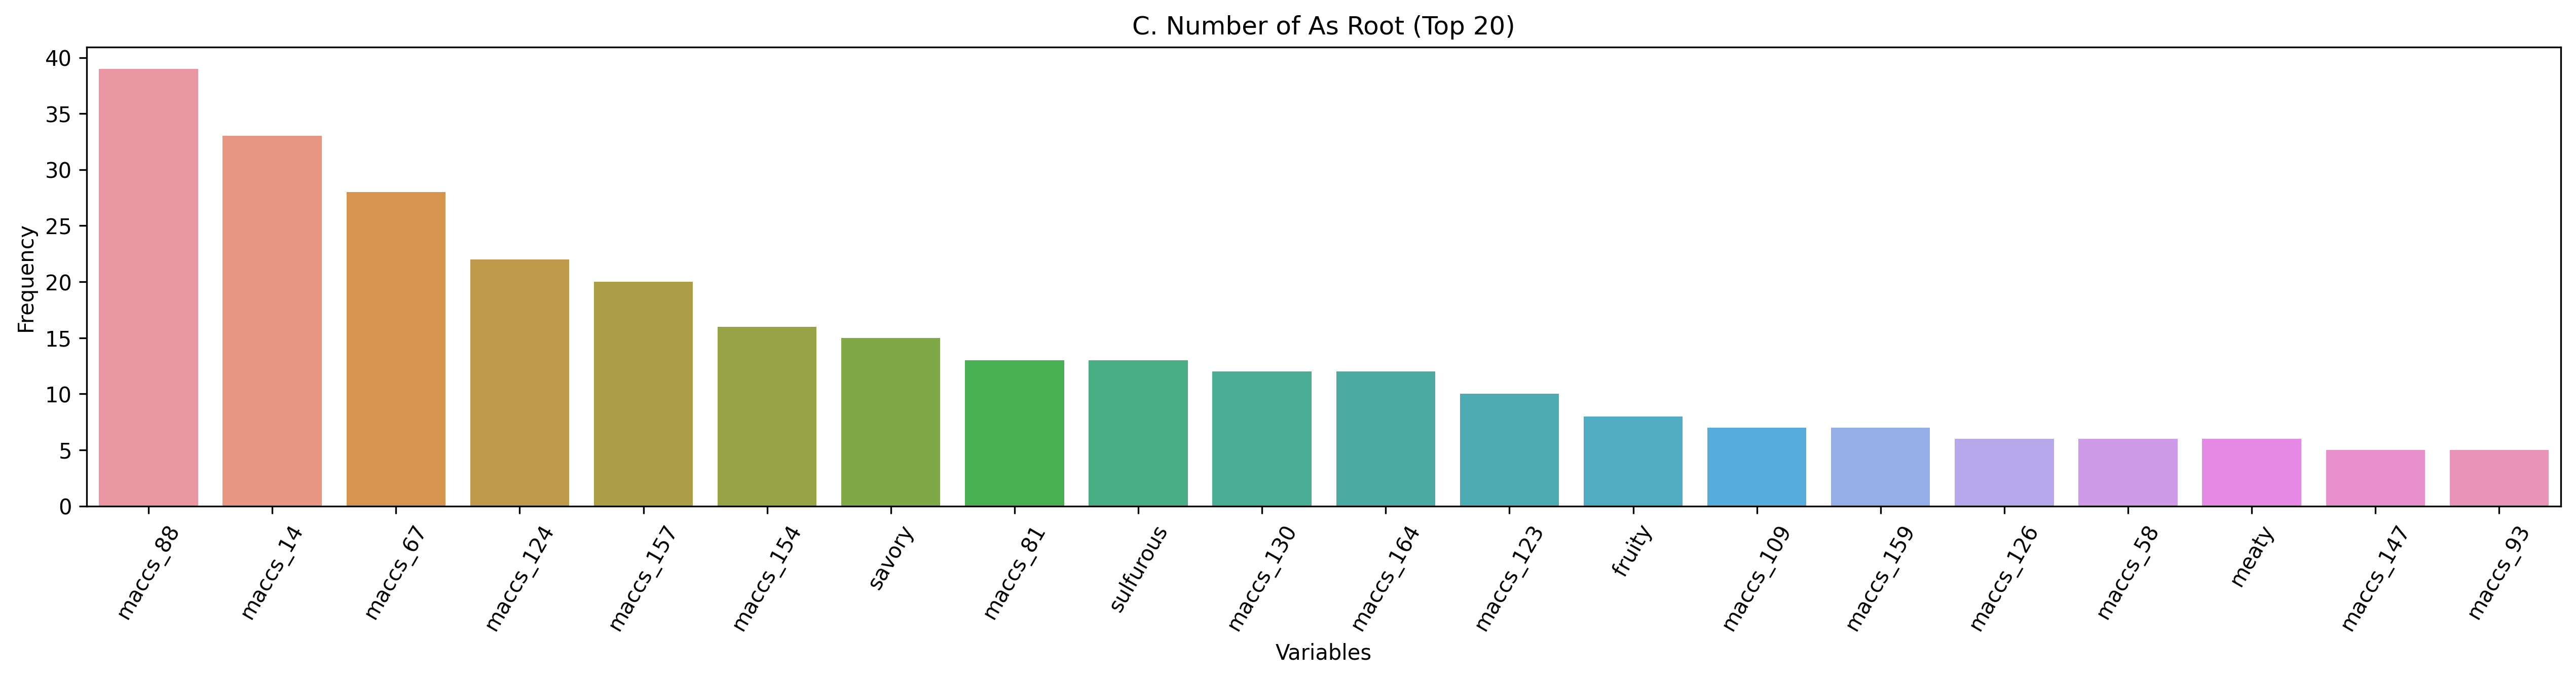

In [96]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(nsr_pd['variable'][:20], nsr_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Frequency')

plt.title('C. Number of As Root (Top 20)')

### SS SUM OF SCORE

In [97]:
ss_pd = pd.DataFrame(ss,columns=['variables','importance'])
ss_pd['variable'] = ss_pd.variables.apply(RV0)
ss_pd['type'] = ss_pd.variables.apply(RV1)
ss_pd['id'] = ss_pd.variables.apply(RV2)

In [98]:
ss_pd.head()

,variables,importance,variable,type,id
0,"(maccs_88, 4, 168)",19814.656708,maccs_88,4,168
1,"(maccs_14, 4, 60)",7667.205950,maccs_14,4,60
2,"(maccs_67, 4, 145)",5653.001567,maccs_67,4,145
3,"(maccs_124, 4, 43)",4415.078958,maccs_124,4,43
4,"(maccs_164, 4, 87)",3948.886309,maccs_164,4,87


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'D. Sum of Score (Top 20)')

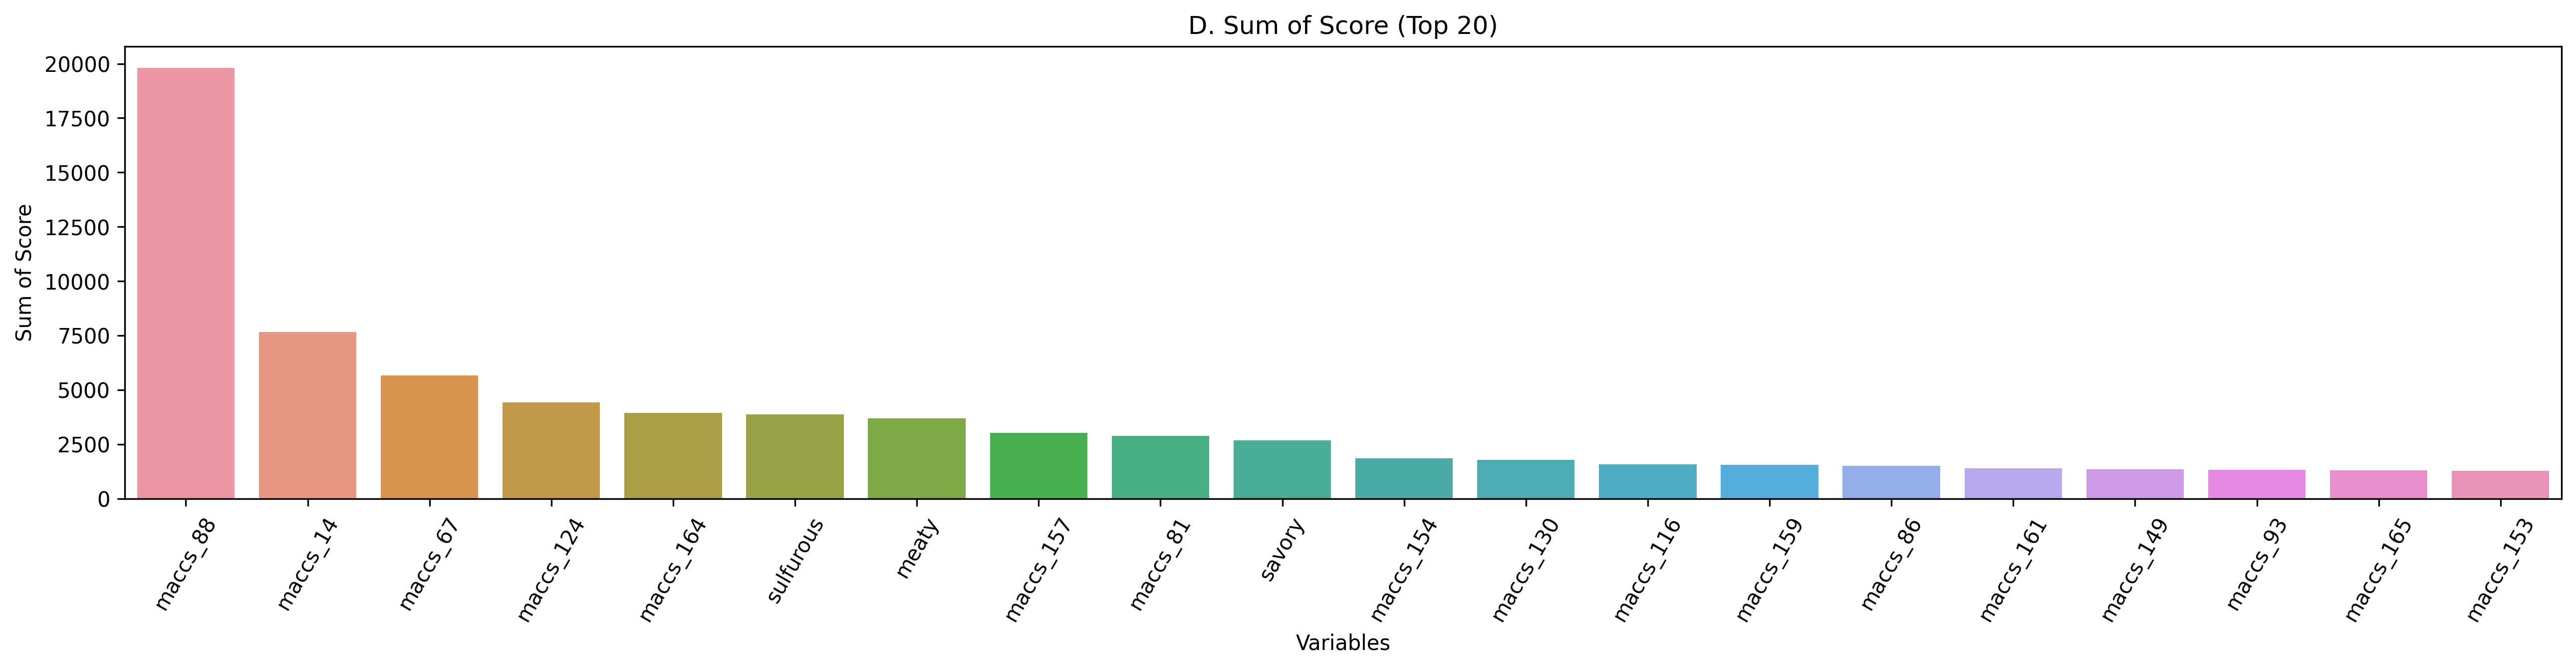

In [99]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(ss_pd['variable'][:20], ss_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Sum of Score')

plt.title('D. Sum of Score (Top 20)')

### Overall Summary


In [100]:
mda_pd.reset_index(inplace=True)
mdauc_pd.reset_index(inplace=True)
nsr_pd.reset_index(inplace=True)
ss_pd.reset_index(inplace=True)

In [101]:
df0 = pd.merge(mda_pd,mdauc_pd,on=['variable','type',	'id'],how='outer')
df1 = pd.merge(df0,nsr_pd,on=['variable','type',	'id'],how='outer')
df2 = pd.merge(df1,ss_pd,on=['variable','type',	'id'],how='outer')
df2.head()

,index_x,variables_x,importance_x,variable,type,id,index_y,variables_y,importance_y,index_x,variables_x,importance_x,index_y,variables_y,importance_y
0,0,"(sulfurous, 4, 190)",0.001919,sulfurous,4,190,8,"(sulfurous, 4, 190)",0.001408,8.0,"(sulfurous, 4, 190)",13.0,5.0,"(sulfurous, 4, 190)",3867.841239
1,1,"(meaty, 4, 181)",0.001535,meaty,4,181,3,"(meaty, 4, 181)",0.003137,17.0,"(meaty, 4, 181)",6.0,6.0,"(meaty, 4, 181)",3693.401000
2,2,"(maccs_14, 4, 60)",0.000768,maccs_14,4,60,195,"(maccs_14, 4, 60)",-0.005264,1.0,"(maccs_14, 4, 60)",33.0,1.0,"(maccs_14, 4, 60)",7667.205950
3,3,"(vegetable, 4, 193)",0.000768,vegetable,4,193,30,"(vegetable, 4, 193)",0.000298,NaN,NaN,NaN,23.0,"(vegetable, 4, 193)",1038.401644
4,4,"(maccs_164, 4, 87)",0.000768,maccs_164,4,87,7,"(maccs_164, 4, 87)",0.001446,10.0,"(maccs_164, 4, 87)",12.0,4.0,"(maccs_164, 4, 87)",3948.886309


In [102]:
df2['ranking'] = df2[['index_x','index_y']].sum(axis=1)

In [103]:
df2.sort_values(by=['ranking'],ascending=True)[['variable','ranking']].head(10)

,variable,ranking
0,sulfurous,21.0
4,maccs_164,25.0
1,meaty,27.0
54,maccs_88,54.0
3,vegetable,56.0
10,green,79.0
16,maccs_43,83.0
19,maccs_44,85.0
11,maccs_47,86.0
27,maccs_58,88.0


# Fragment

In [104]:
label = "onion"

classes = F_onion[label].unique().tolist()
print(f"Label classes: {classes}")

F_onion[label] = F_onion[label].map(classes.index)

Label classes: [0, 1]


In [105]:
train_ds_pd, test_ds_pd = split_dataset(F_onion.iloc[:,3:])
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

2609 examples in training, 1127 examples for testing.


In [106]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label='onion')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label='onion')

In [107]:
# %set_cell_height 300

# Specify the model.
model_2 = tfdf.keras.RandomForestModel(compute_oob_variable_importances=True)

# Optionally, add evaluation metrics.
model_2.compile(
    metrics=["accuracy","AUC","Recall","Precision"])

In [108]:
# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_2.fit(x=train_ds)

41/41 [==============================] - 1s 7ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 41
[INFO kernel.cc:393] Number of examples: 2609
[INFO kernel.cc:769] Dataset:
Number of records: 2609
Number of columns: 63

Number of columns by type:
	NUMERICAL: 32 (50.7937%)
	CATEGORICAL: 31 (49.2063%)

Columns:

NUMERICAL: 32 (50.7937%)
	0: "Br" NUMERICAL mean:0 min:0 max:0 sd:0
	1: "Cl" NUMERICAL mean:0.00114987 min:0 max:3 sd:0.058722
	2: "F" NUMERICAL mean:0 min:0 max:0 sd:0
	7: "carbonyl" NUMERICAL mean:0.597547 min:0 max:4 sd:0.613326
	8: "carboxyl" NUMERICAL mean:0.260253 min:0 max:3 sd:0.460926
	19: "hydroxy" NUMERICAL mean:0.25642 min:0 max:2 sd:0.438408
	20: "keto" NUMERICAL mean:0.302798 min:0 max:3 sd:0.556087
	21: "main_C" NUMERICAL mean:7.89115 min:1 max:23 sd:3.66931
	22: "main_I" NUMERICAL mean:0 min:0 max:0 sd:0
	23: "main_N" NUMERICAL mean:0.105404 min:0 max:4 sd:0.366274
	24: "main_O" NUMERICAL mean:0.838635 min:0 max:4 sd:0.

In [109]:
evaluation = model_2.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

18/18 [==============================] - 1s 9ms/step - loss: 0.0000e+00 - accuracy: 0.9654 - auc: 0.9320 - recall: 0.2083 - precision: 0.9091

loss: 0.0000
accuracy: 0.9654
auc: 0.9320
recall: 0.2083
precision: 0.9091


In [110]:
inspector = model_2.make_inspector()

In [111]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 MEAN_MIN_DEPTH
	 MEAN_DECREASE_IN_PRAUC_2_VS_OTHERS
	 NUM_NODES
	 MEAN_DECREASE_IN_AUC_2_VS_OTHERS
	 SUM_SCORE
	 MEAN_DECREASE_IN_ACCURACY
	 NUM_AS_ROOT
	 MEAN_DECREASE_IN_AP_2_VS_OTHERS


In [112]:
mda = inspector.variable_importances()["MEAN_DECREASE_IN_ACCURACY"]
mdauc = inspector.variable_importances()["MEAN_DECREASE_IN_AUC_2_VS_OTHERS"]
nsr = inspector.variable_importances()['NUM_AS_ROOT']
ss = inspector.variable_importances()['SUM_SCORE']

In [ ]:
def RV0(series):
  return series[0]

def RV1(series):
  return series[1]

def RV2(series):
  return series[2]


### MDA MEAN DECREASE IN ACCURACY

In [114]:
mda_pd = pd.DataFrame(mda,columns=['variables','importance'])
mda_pd['variable'] = mda_pd.variables.apply(RV0)
mda_pd['type'] = mda_pd.variables.apply(RV1)
mda_pd['id'] = mda_pd.variables.apply(RV2)

In [115]:
mda_pd.head()

,variables,importance,variable,type,id
0,"(main_S, 1, 25)",0.008816,main_S,1,25
1,"(main_N, 1, 23)",0.002683,main_N,1,23
2,"(ring_num, 1, 39)",0.001533,ring_num,1,39
3,"(main_O, 1, 24)",0.001533,main_O,1,24
4,"(savory, 4, 42)",0.001150,savory,4,42


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'A. Mean Decrease In Accuracy (Top 20)')

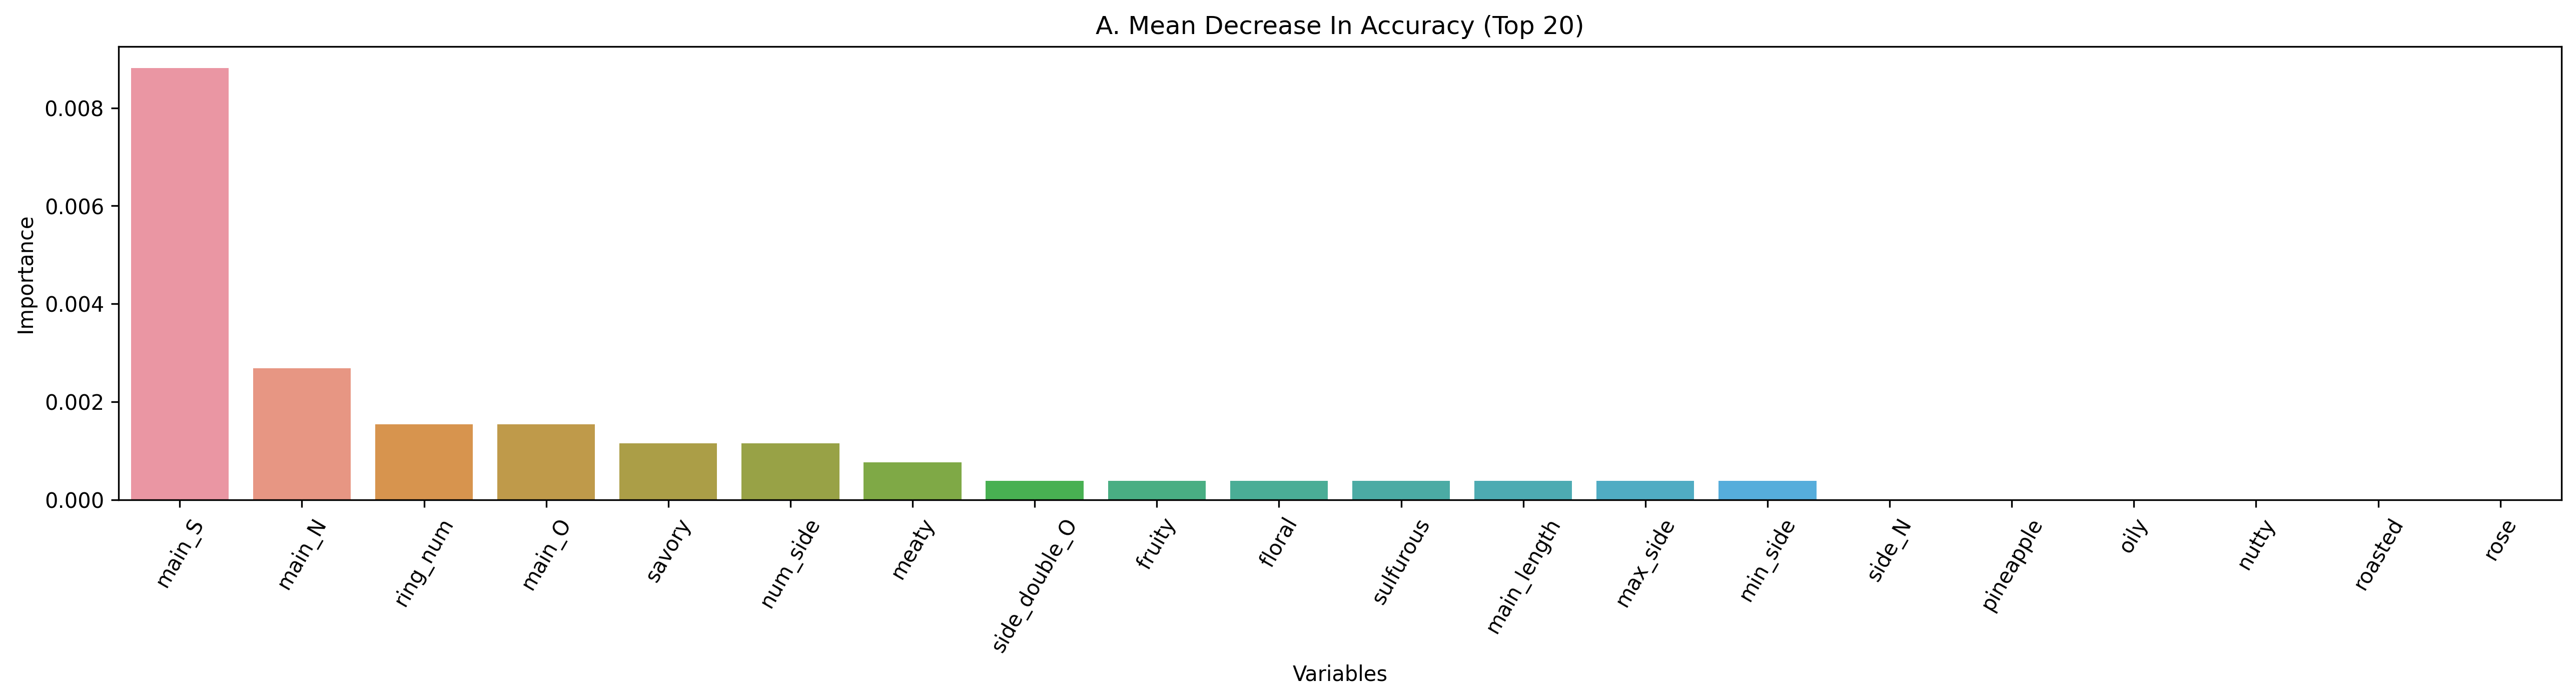

In [116]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(mda_pd['variable'][:20], mda_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Importance')

plt.title('A. Mean Decrease In Accuracy (Top 20)')

### MDAUC MEAN_DECREASE_IN_AUC_2_VS_OTHERS

In [117]:
mdauc_pd = pd.DataFrame(mdauc,columns=['variables','importance'])
mdauc_pd['variable'] = mdauc_pd.variables.apply(RV0)
mdauc_pd['type'] = mdauc_pd.variables.apply(RV1)
mdauc_pd['id'] = mdauc_pd.variables.apply(RV2)

In [118]:
mdauc_pd.head()

,variables,importance,variable,type,id
0,"(main_S, 1, 25)",0.037011,main_S,1,25
1,"(sulfurous, 4, 53)",0.013833,sulfurous,4,53
2,"(side_double_C, 1, 48)",0.005582,side_double_C,1,48
3,"(fruity, 4, 16)",0.004131,fruity,4,16
4,"(main_N, 1, 23)",0.002213,main_N,1,23


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'B. Mean Decrease In ROC AUC (Top 20)')

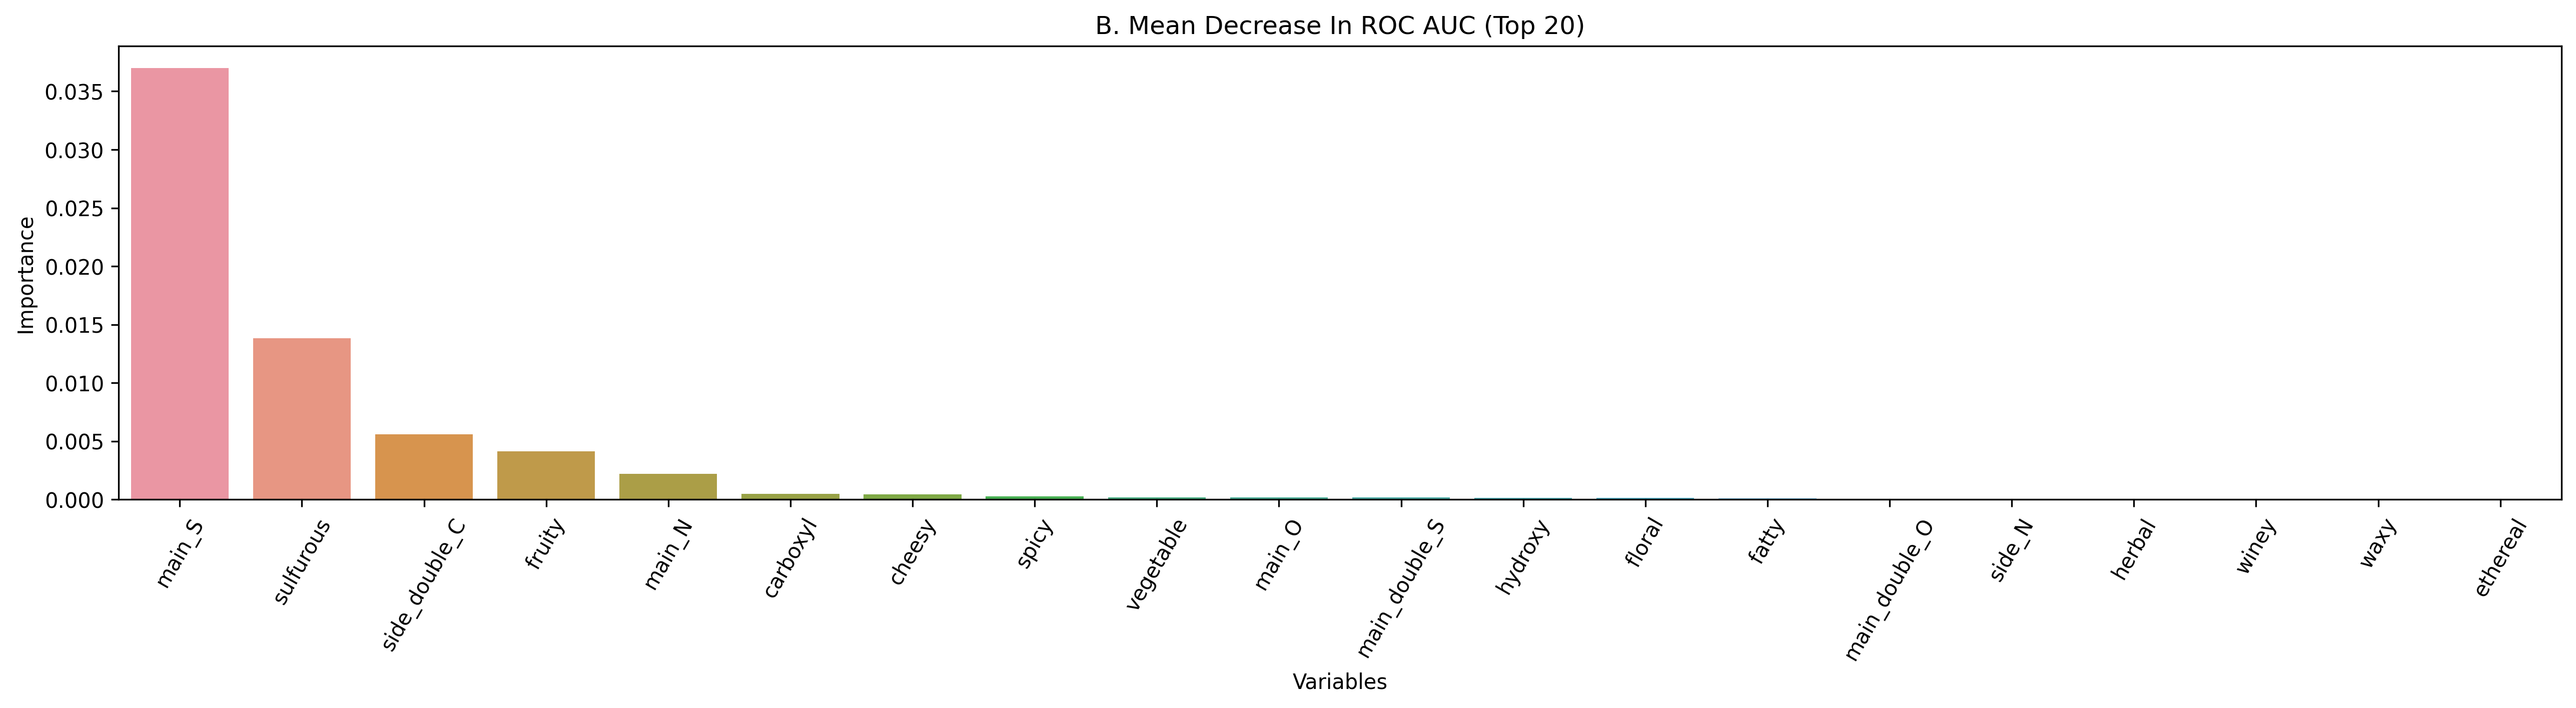

In [119]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(mdauc_pd['variable'][:20], mdauc_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Importance')

plt.title('B. Mean Decrease In ROC AUC (Top 20)')

### NSR NUM_AS_ROOT

In [120]:
nsr_pd = pd.DataFrame(nsr,columns=['variables','importance'])
nsr_pd['variable'] = nsr_pd.variables.apply(RV0)
nsr_pd['type'] = nsr_pd.variables.apply(RV1)
nsr_pd['id'] = nsr_pd.variables.apply(RV2)

In [121]:
nsr_pd.head()

,variables,importance,variable,type,id
0,"(main_S, 1, 25)",47.0,main_S,1,25
1,"(main_C, 1, 21)",31.0,main_C,1,21
2,"(sulfurous, 4, 53)",30.0,sulfurous,4,53
3,"(main_O, 1, 24)",27.0,main_O,1,24
4,"(savory, 4, 42)",27.0,savory,4,42


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'C. Number of As Root (Top 20)')

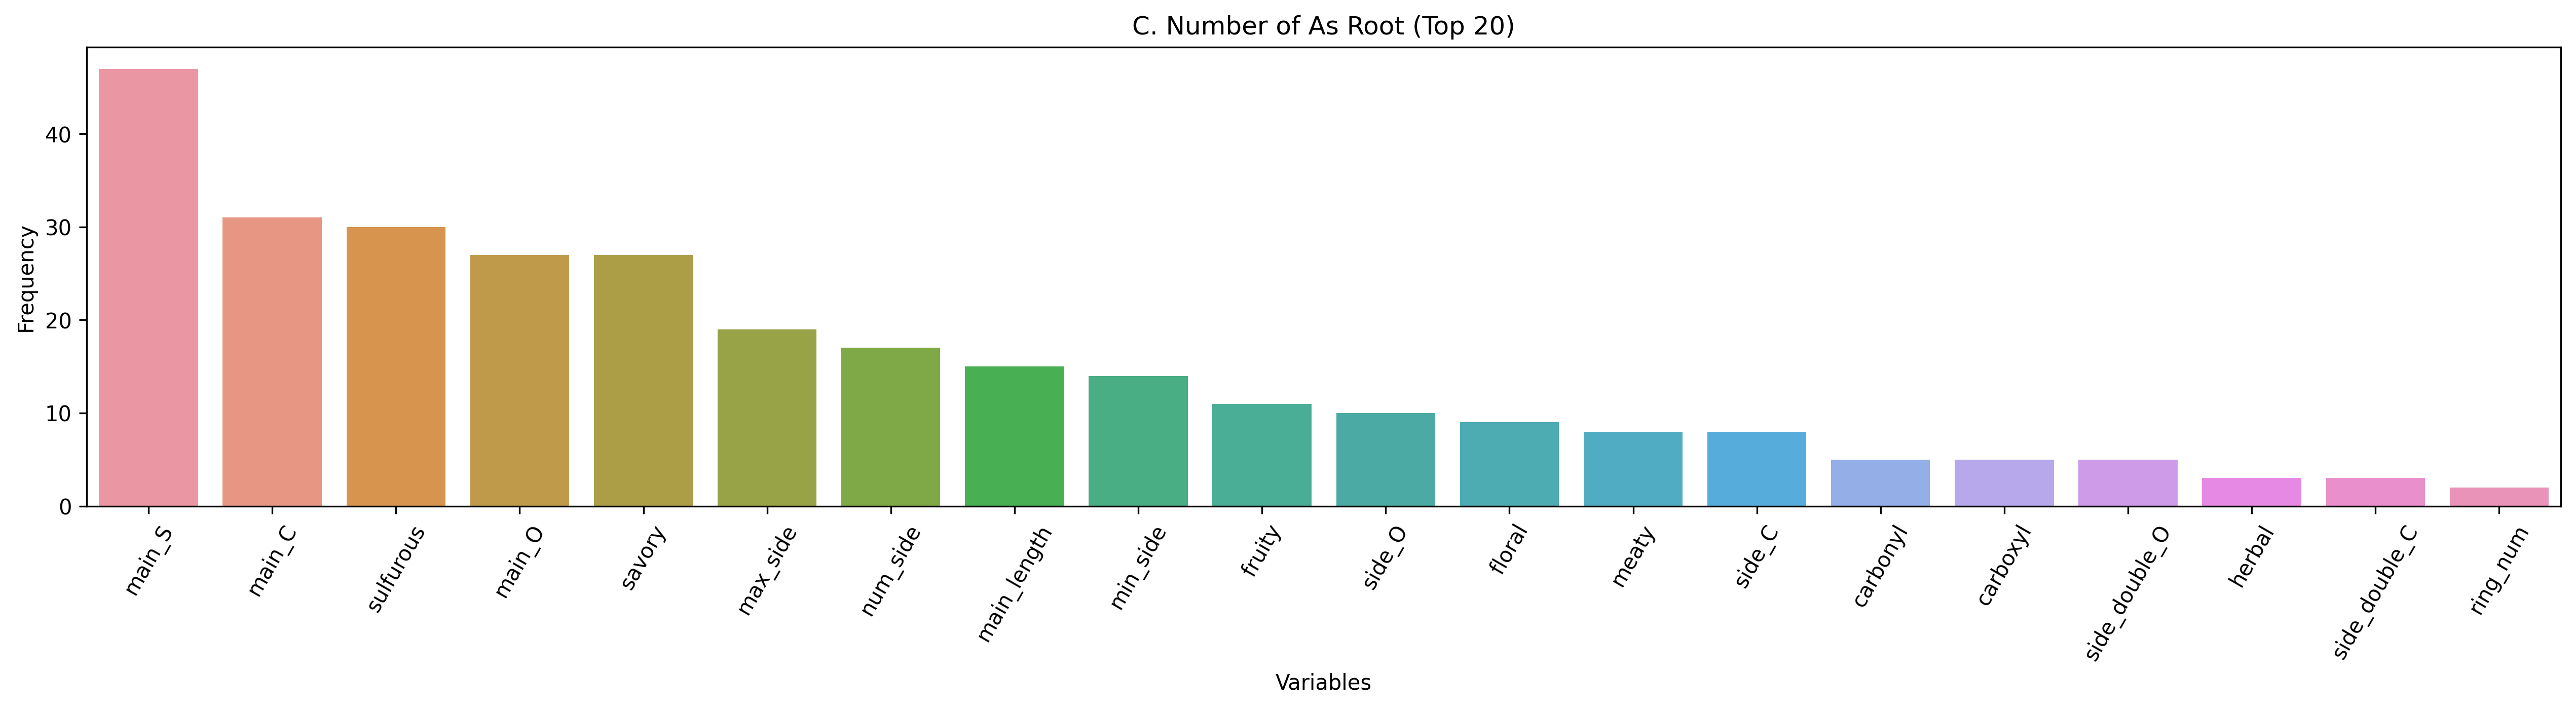

In [122]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(nsr_pd['variable'][:20], nsr_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Frequency')

plt.title('C. Number of As Root (Top 20)')

### SS SUM OF SCORE

In [123]:
ss_pd = pd.DataFrame(ss,columns=['variables','importance'])
ss_pd['variable'] = ss_pd.variables.apply(RV0)
ss_pd['type'] = ss_pd.variables.apply(RV1)
ss_pd['id'] = ss_pd.variables.apply(RV2)

In [124]:
ss_pd.head()

,variables,importance,variable,type,id
0,"(main_S, 1, 25)",23644.621447,main_S,1,25
1,"(sulfurous, 4, 53)",9403.134503,sulfurous,4,53
2,"(main_C, 1, 21)",7720.998686,main_C,1,21
3,"(savory, 4, 42)",5629.697653,savory,4,42
4,"(main_length, 1, 30)",5112.386629,main_length,1,30


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'D. Sum of Score (Top 20)')

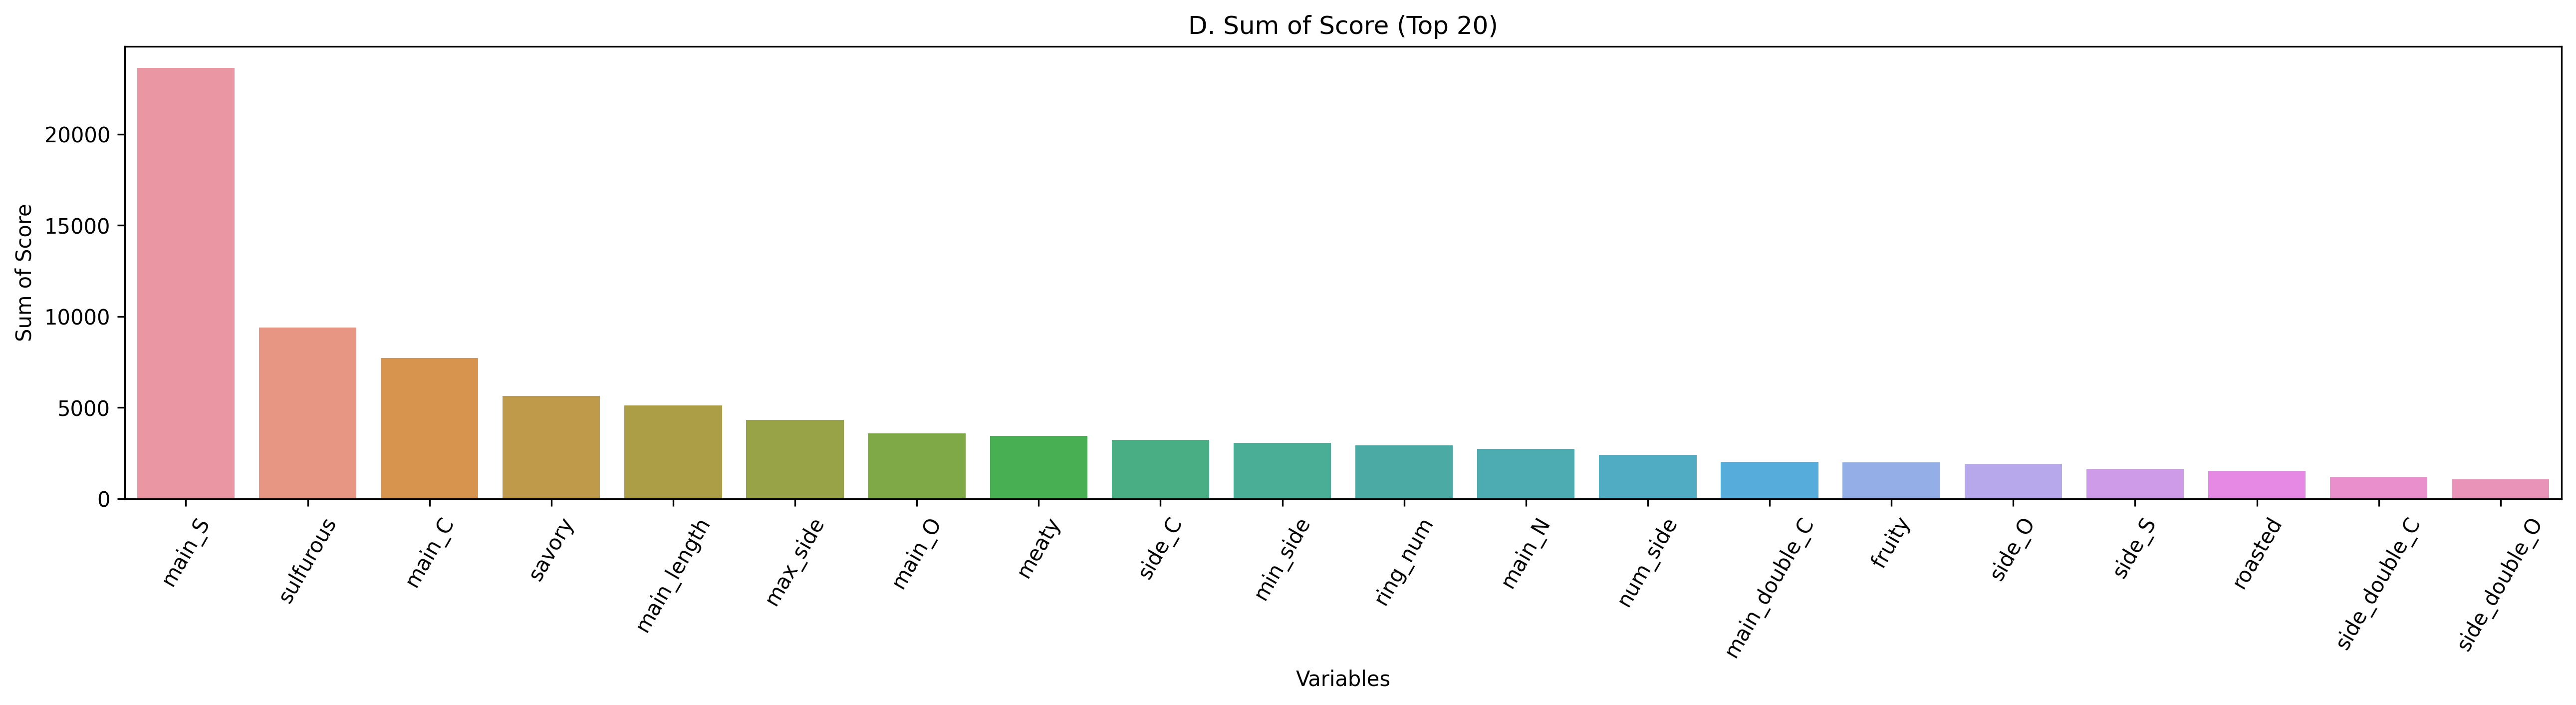

In [125]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(ss_pd['variable'][:20], ss_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Sum of Score')

plt.title('D. Sum of Score (Top 20)')

### Overall Summary


In [126]:
mda_pd.reset_index(inplace=True)
mdauc_pd.reset_index(inplace=True)
nsr_pd.reset_index(inplace=True)
ss_pd.reset_index(inplace=True)

In [127]:
df0 = pd.merge(mda_pd,mdauc_pd,on=['variable','type',	'id'],how='outer')
df1 = pd.merge(df0,nsr_pd,on=['variable','type',	'id'],how='outer')
df2 = pd.merge(df1,ss_pd,on=['variable','type',	'id'],how='outer')
df2.head()

,index_x,variables_x,importance_x,variable,type,id,index_y,variables_y,importance_y,index_x,variables_x,importance_x,index_y,variables_y,importance_y
0,0,"(main_S, 1, 25)",0.008816,main_S,1,25,0,"(main_S, 1, 25)",0.037011,0.0,"(main_S, 1, 25)",47.0,0.0,"(main_S, 1, 25)",23644.621447
1,1,"(main_N, 1, 23)",0.002683,main_N,1,23,4,"(main_N, 1, 23)",0.002213,NaN,NaN,NaN,11.0,"(main_N, 1, 23)",2725.188598
2,2,"(ring_num, 1, 39)",0.001533,ring_num,1,39,45,"(ring_num, 1, 39)",-0.000370,19.0,"(ring_num, 1, 39)",2.0,10.0,"(ring_num, 1, 39)",2915.303487
3,3,"(main_O, 1, 24)",0.001533,main_O,1,24,9,"(main_O, 1, 24)",0.000179,3.0,"(main_O, 1, 24)",27.0,6.0,"(main_O, 1, 24)",3584.061391
4,4,"(savory, 4, 42)",0.001150,savory,4,42,61,"(savory, 4, 42)",-0.005913,4.0,"(savory, 4, 42)",27.0,3.0,"(savory, 4, 42)",5629.697653


In [128]:
df2['ranking'] = df2[['index_x','index_y']].sum(axis=1)

In [129]:
df2.sort_values(by=['ranking'],ascending=True)[['variable','ranking']].head(10)

,variable,ranking
0,main_S,0.0
10,sulfurous,14.0
1,main_N,16.0
3,main_O,21.0
8,fruity,34.0
20,side_I,44.0
29,triple_C,52.0
9,floral,55.0
30,triple_N,56.0
33,Br,62.0


# MACCS + Fragment

In [130]:
label = "onion"

classes = MF_onion[label].unique().tolist()
print(f"Label classes: {classes}")

MF_onion[label] = MF_onion[label].map(classes.index)

Label classes: [0, 1]


In [131]:
train_ds_pd, test_ds_pd = split_dataset(MF_onion.iloc[:,3:])
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

2658 examples in training, 1078 examples for testing.


In [132]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label='onion')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label='onion')

In [133]:
# %set_cell_height 300

# Specify the model.
model_3 = tfdf.keras.RandomForestModel(compute_oob_variable_importances=True)

# Optionally, add evaluation metrics.
model_3.compile(
    metrics=["accuracy","AUC","Recall","Precision"])

In [134]:
# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_3.fit(x=train_ds)

42/42 [==============================] - 2s 18ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 42
[INFO kernel.cc:393] Number of examples: 2658
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column maccs_103 (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column maccs_107 (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column maccs_13 (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column maccs_134 (1 item(s) left) because min_value_count=5 and ma

In [135]:
evaluation = model_3.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

17/17 [==============================] - 3s 23ms/step - loss: 0.0000e+00 - accuracy: 0.9768 - auc: 0.9858 - recall: 0.4524 - precision: 0.9048

loss: 0.0000
accuracy: 0.9768
auc: 0.9858
recall: 0.4524
precision: 0.9048


In [136]:
inspector = model_3.make_inspector()

In [ ]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 MEAN_MIN_DEPTH
	 MEAN_DECREASE_IN_PRAUC_2_VS_OTHERS
	 NUM_NODES
	 MEAN_DECREASE_IN_AUC_2_VS_OTHERS
	 SUM_SCORE
	 MEAN_DECREASE_IN_ACCURACY
	 NUM_AS_ROOT
	 MEAN_DECREASE_IN_AP_2_VS_OTHERS


In [137]:
mda = inspector.variable_importances()["MEAN_DECREASE_IN_ACCURACY"]
mdauc = inspector.variable_importances()["MEAN_DECREASE_IN_AUC_2_VS_OTHERS"]
nsr = inspector.variable_importances()['NUM_AS_ROOT']
ss = inspector.variable_importances()['SUM_SCORE']

In [ ]:
def RV0(series):
  return series[0]

def RV1(series):
  return series[1]

def RV2(series):
  return series[2]


### MDA MEAN DECREASE IN ACCURACY

In [138]:
mda_pd = pd.DataFrame(mda,columns=['variables','importance'])
mda_pd['variable'] = mda_pd.variables.apply(RV0)
mda_pd['type'] = mda_pd.variables.apply(RV1)
mda_pd['id'] = mda_pd.variables.apply(RV2)

In [139]:
mda_pd.head()

,variables,importance,variable,type,id
0,"(maccs_153, 4, 82)",0.000752,maccs_153,4,82
1,"(maccs_154, 4, 83)",0.000752,maccs_154,4,83
2,"(side_O, 1, 213)",0.000752,side_O,1,213
3,"(maccs_123, 4, 49)",0.000752,maccs_123,4,49
4,"(maccs_112, 4, 37)",0.000752,maccs_112,4,37


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'A. Mean Decrease In Accuracy (Top 20)')

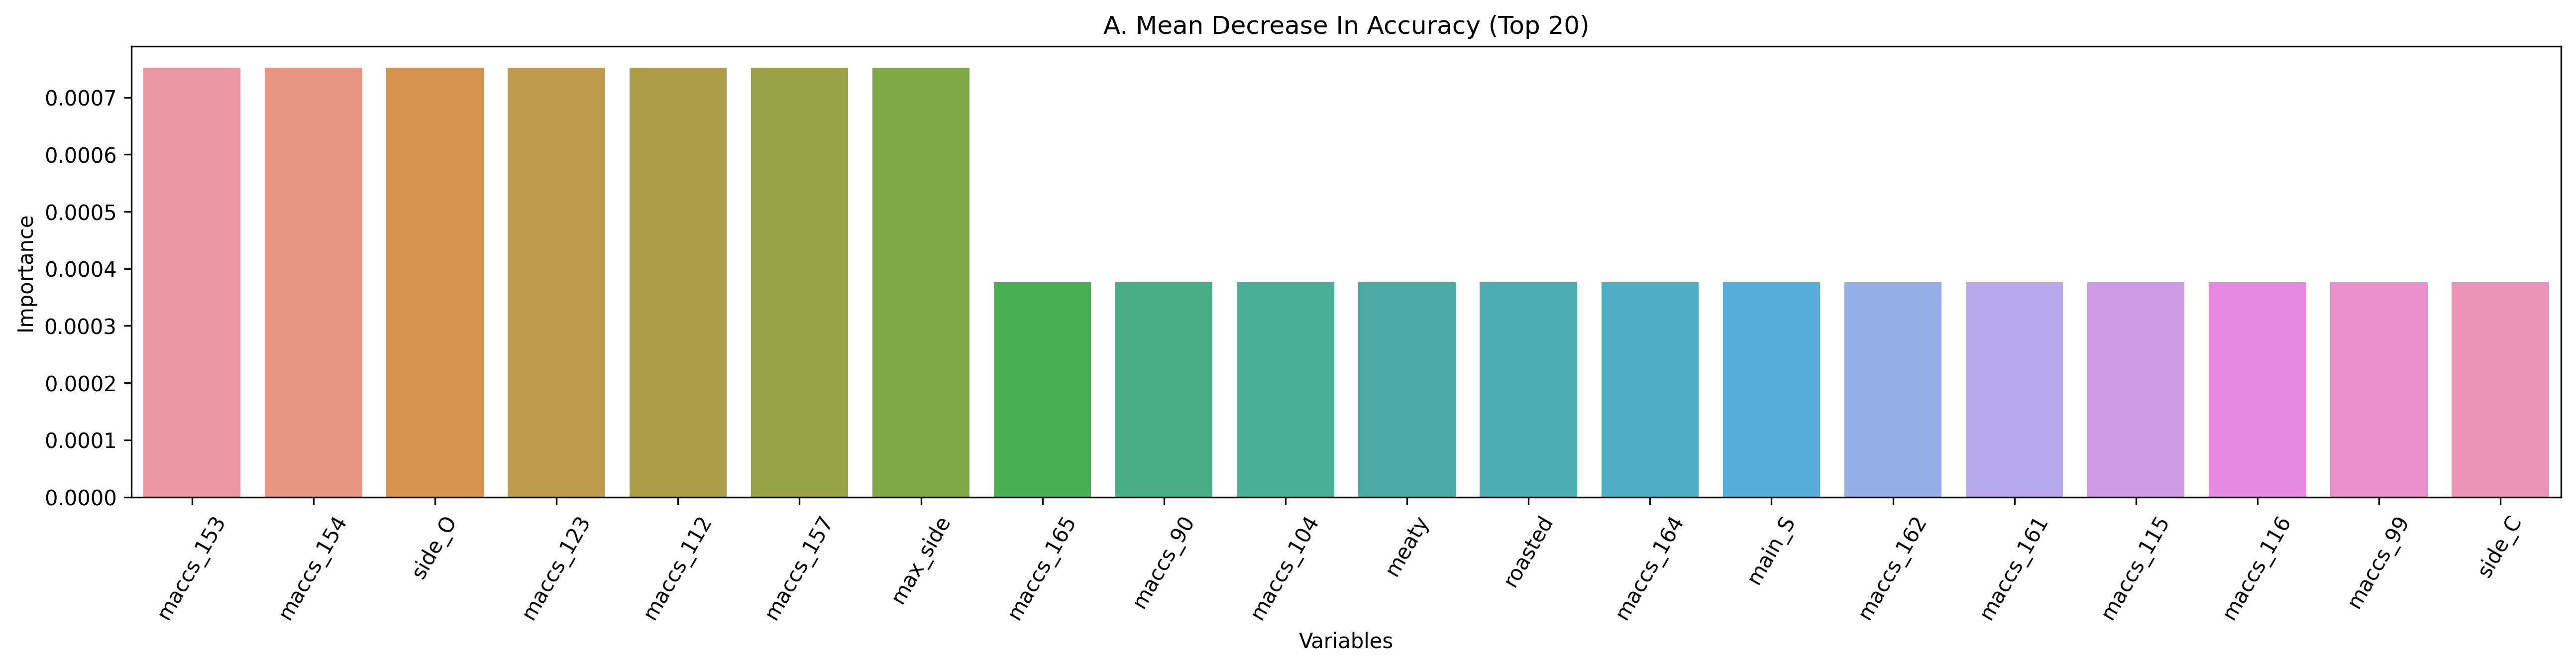

In [140]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(mda_pd['variable'][:20], mda_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Importance')

plt.title('A. Mean Decrease In Accuracy (Top 20)')

### MDAUC MEAN_DECREASE_IN_AUC_2_VS_OTHERS

In [141]:
mdauc_pd = pd.DataFrame(mdauc,columns=['variables','importance'])
mdauc_pd['variable'] = mdauc_pd.variables.apply(RV0)
mdauc_pd['type'] = mdauc_pd.variables.apply(RV1)
mdauc_pd['id'] = mdauc_pd.variables.apply(RV2)

In [142]:
mdauc_pd.head()

,variables,importance,variable,type,id
0,"(maccs_88, 4, 175)",0.013105,maccs_88,4,175
1,"(main_S, 1, 192)",0.009813,main_S,1,192
2,"(maccs_81, 4, 168)",0.006103,maccs_81,4,168
3,"(maccs_138, 4, 65)",0.005000,maccs_138,4,65
4,"(maccs_162, 4, 92)",0.004186,maccs_162,4,92


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'B. Mean Decrease In ROC AUC (Top 20)')

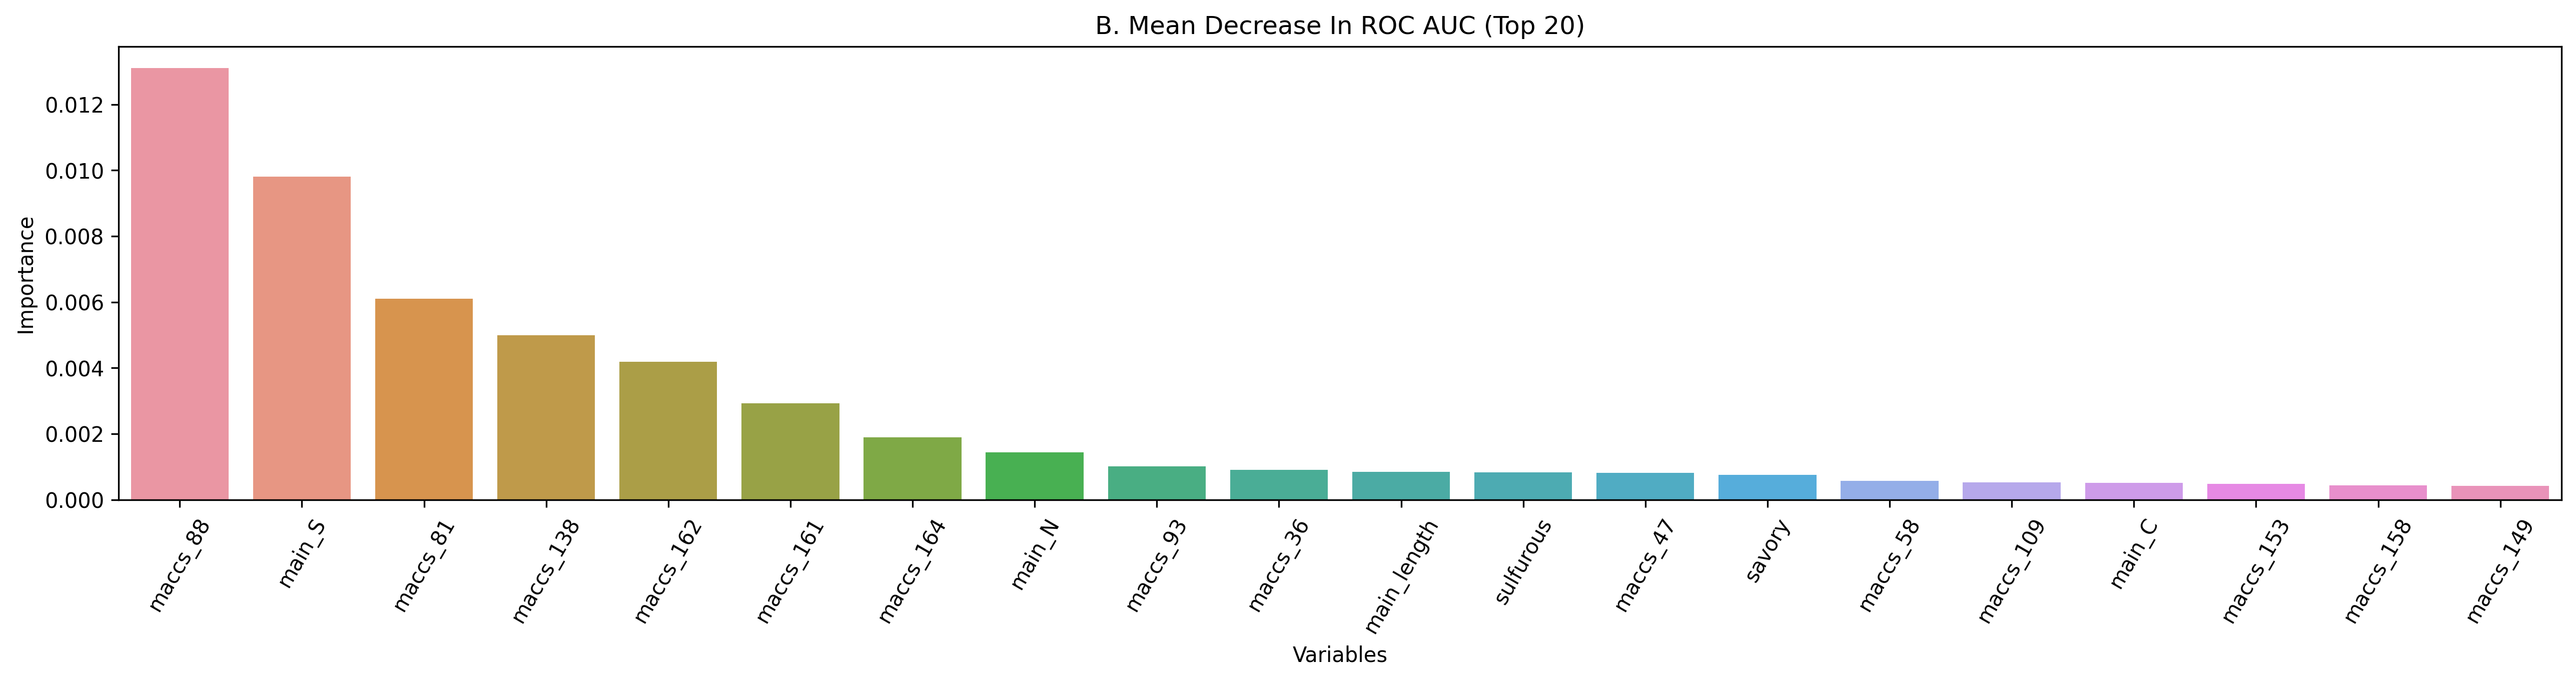

In [143]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(mdauc_pd['variable'][:20], mdauc_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Importance')

plt.title('B. Mean Decrease In ROC AUC (Top 20)')

### NSR NUM_AS_ROOT

In [144]:
nsr_pd = pd.DataFrame(nsr,columns=['variables','importance'])
nsr_pd['variable'] = nsr_pd.variables.apply(RV0)
nsr_pd['type'] = nsr_pd.variables.apply(RV1)
nsr_pd['id'] = nsr_pd.variables.apply(RV2)

In [145]:
nsr_pd.head()

,variables,importance,variable,type,id
0,"(maccs_88, 4, 175)",39.0,maccs_88,4,175
1,"(maccs_14, 4, 67)",32.0,maccs_14,4,67
2,"(maccs_124, 4, 50)",18.0,maccs_124,4,50
3,"(maccs_157, 4, 86)",18.0,maccs_157,4,86
4,"(sulfurous, 4, 220)",17.0,sulfurous,4,220


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'C. Number of As Root (Top 20)')

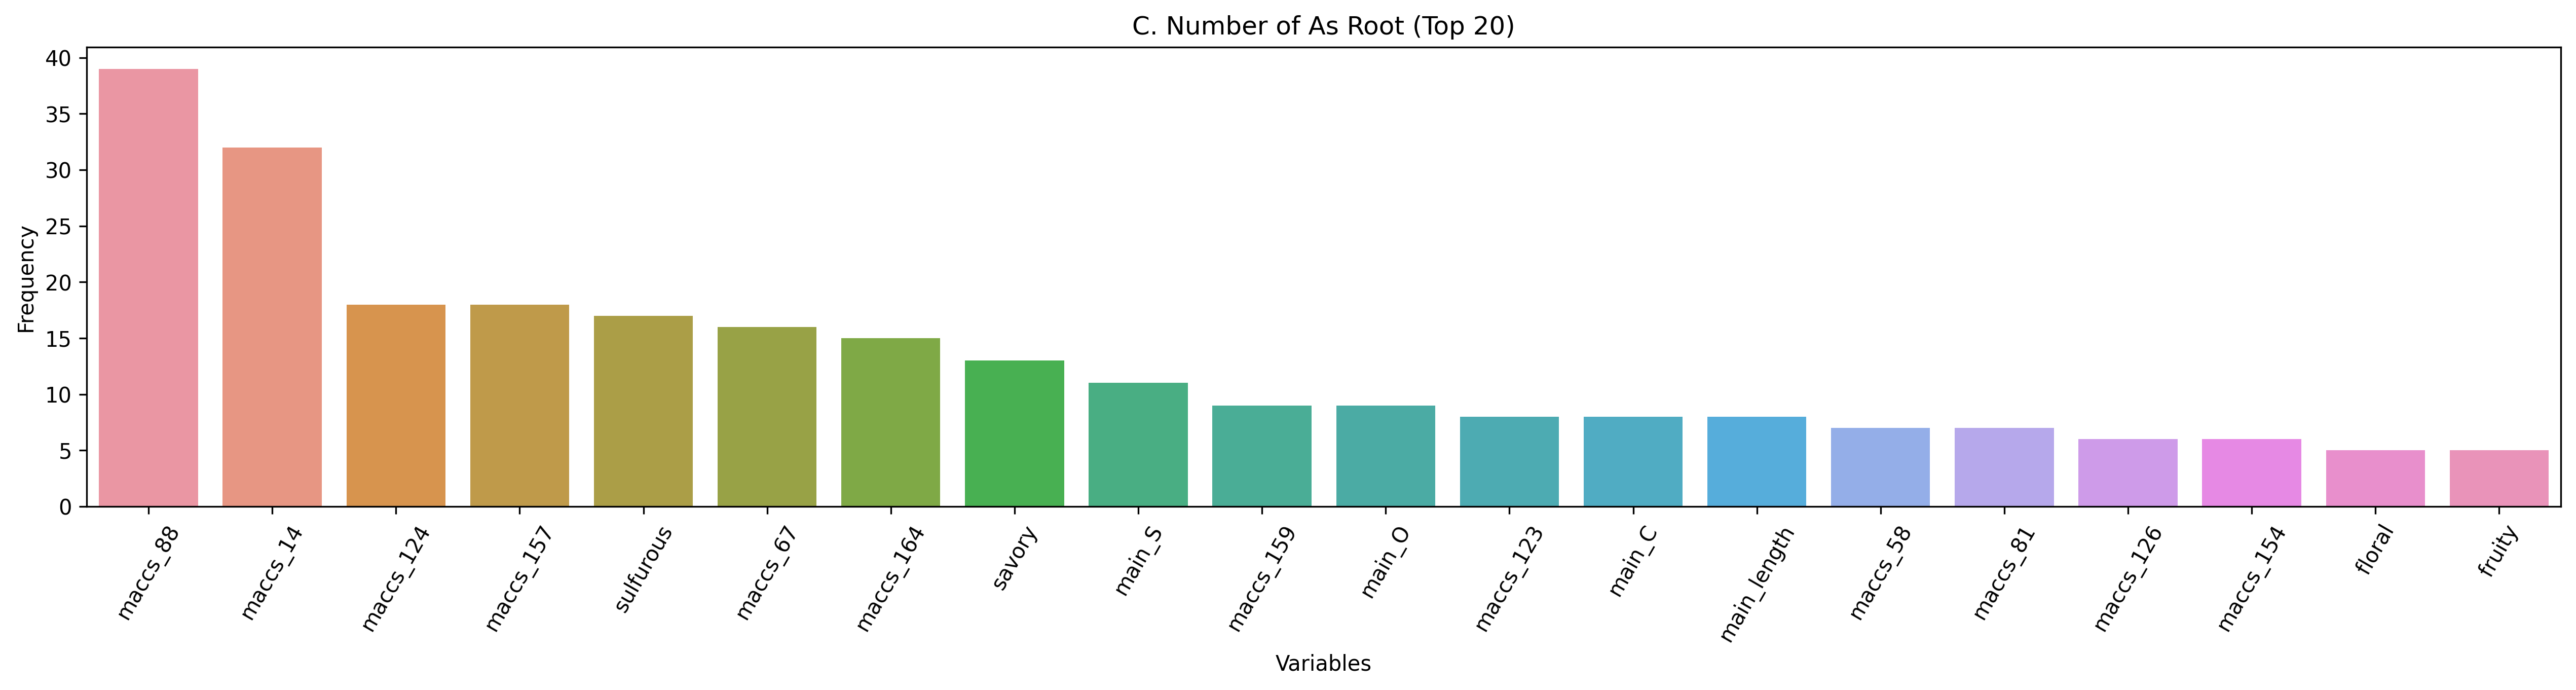

In [146]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(nsr_pd['variable'][:20], nsr_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Frequency')

plt.title('C. Number of As Root (Top 20)')

### SS SUM OF SCORE

In [147]:
ss_pd = pd.DataFrame(ss,columns=['variables','importance'])
ss_pd['variable'] = ss_pd.variables.apply(RV0)
ss_pd['type'] = ss_pd.variables.apply(RV1)
ss_pd['id'] = ss_pd.variables.apply(RV2)

In [148]:
ss_pd.head()

,variables,importance,variable,type,id
0,"(maccs_88, 4, 175)",18537.314374,maccs_88,4,175
1,"(main_S, 1, 192)",6927.238748,main_S,1,192
2,"(sulfurous, 4, 220)",4104.919014,sulfurous,4,220
3,"(maccs_14, 4, 67)",4030.354435,maccs_14,4,67
4,"(main_C, 1, 188)",3286.647369,main_C,1,188


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'D. Sum of Score (Top 20)')

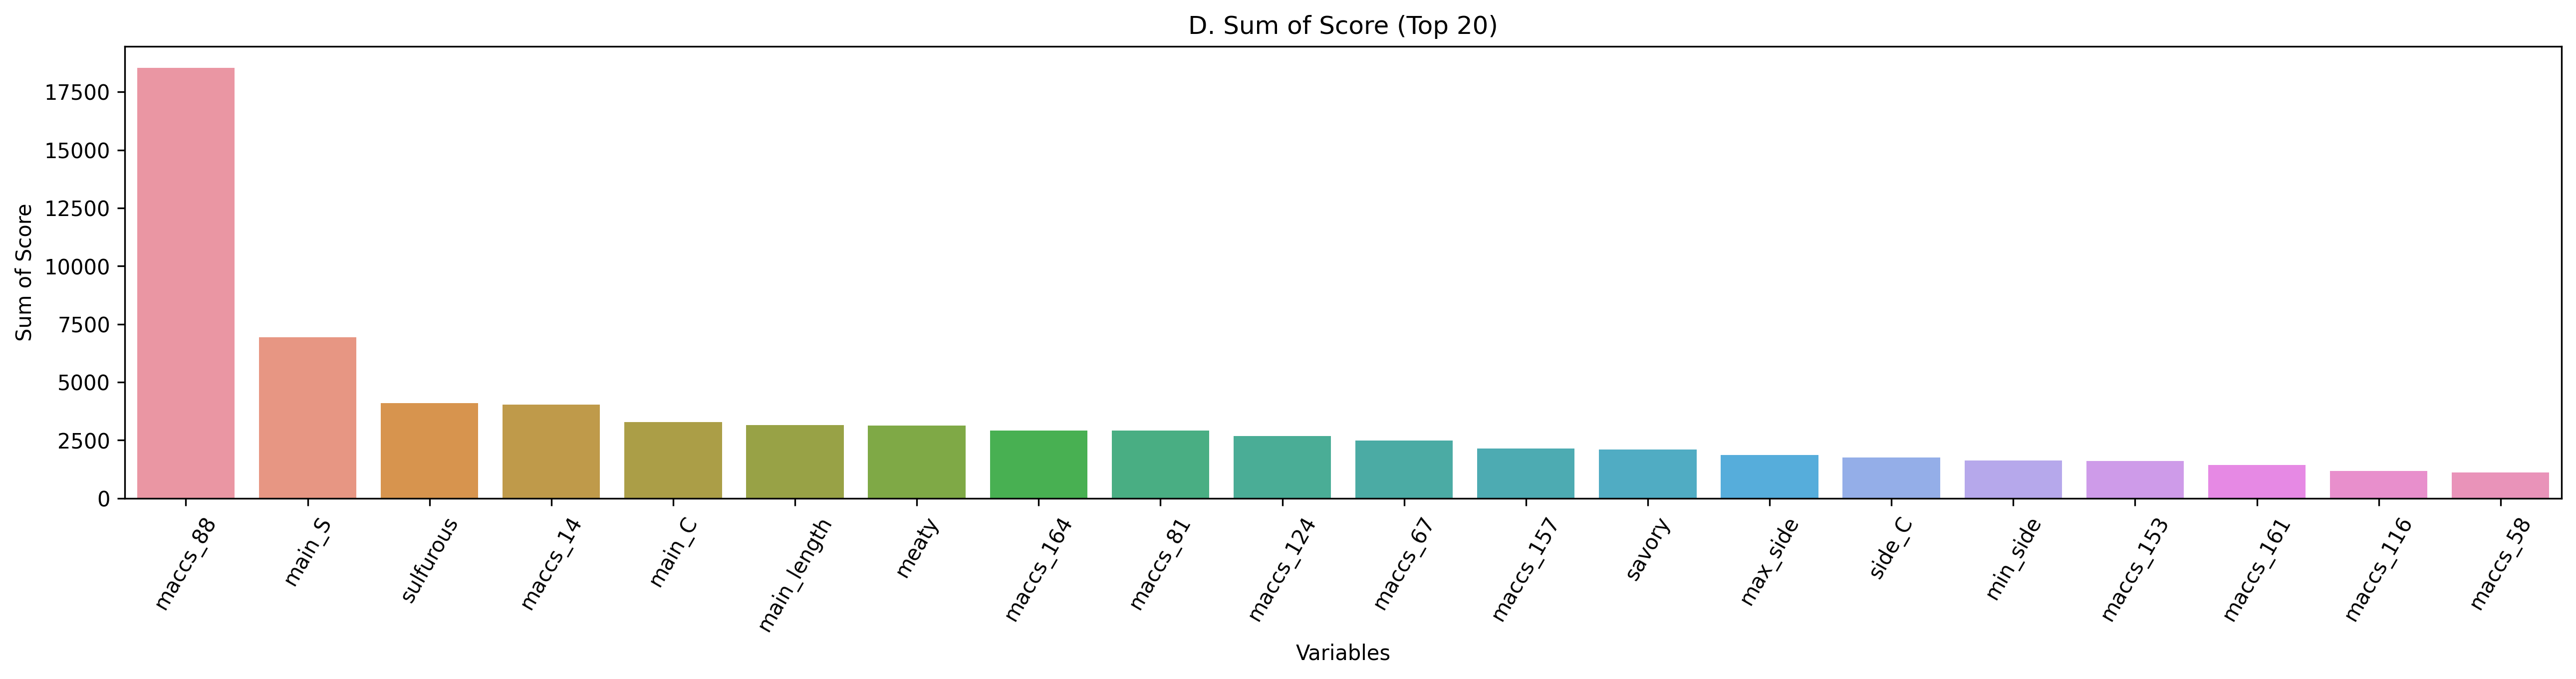

In [149]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(ss_pd['variable'][:20], ss_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Sum of Score')

plt.title('D. Sum of Score (Top 20)')

### Overall Summary


In [150]:
mda_pd.reset_index(inplace=True)
mdauc_pd.reset_index(inplace=True)
nsr_pd.reset_index(inplace=True)
ss_pd.reset_index(inplace=True)

In [151]:
df0 = pd.merge(mda_pd,mdauc_pd,on=['variable','type',	'id'],how='outer')
df1 = pd.merge(df0,nsr_pd,on=['variable','type',	'id'],how='outer')
df2 = pd.merge(df1,ss_pd,on=['variable','type',	'id'],how='outer')
df2.head()

,index_x,variables_x,importance_x,variable,type,id,index_y,variables_y,importance_y,index_x,variables_x,importance_x,index_y,variables_y,importance_y
0,0,"(maccs_153, 4, 82)",0.000752,maccs_153,4,82,17,"(maccs_153, 4, 82)",0.000480,NaN,NaN,NaN,16.0,"(maccs_153, 4, 82)",1609.652573
1,1,"(maccs_154, 4, 83)",0.000752,maccs_154,4,83,23,"(maccs_154, 4, 83)",0.000329,17.0,"(maccs_154, 4, 83)",6.0,26.0,"(maccs_154, 4, 83)",844.308656
2,2,"(side_O, 1, 213)",0.000752,side_O,1,213,220,"(side_O, 1, 213)",-0.000418,22.0,"(side_O, 1, 213)",5.0,23.0,"(side_O, 1, 213)",951.923293
3,3,"(maccs_123, 4, 49)",0.000752,maccs_123,4,49,40,"(maccs_123, 4, 49)",0.000177,11.0,"(maccs_123, 4, 49)",8.0,29.0,"(maccs_123, 4, 49)",771.314504
4,4,"(maccs_112, 4, 37)",0.000752,maccs_112,4,37,27,"(maccs_112, 4, 37)",0.000324,30.0,"(maccs_112, 4, 37)",1.0,63.0,"(maccs_112, 4, 37)",387.282237


In [152]:
df2['ranking'] = df2[['index_x','index_y']].sum(axis=1)

In [154]:
df2.sort_values(by=['ranking'],ascending=True)[['variable','ranking']].head(20)

,variable,ranking
13,main_S,23.0
12,maccs_164,31.0
0,maccs_153,33.0
15,maccs_161,37.0
22,maccs_81,47.0
1,maccs_154,67.0
26,maccs_149,73.0
16,maccs_115,79.0
3,maccs_123,83.0
14,maccs_162,90.0
